In [1]:
import pandas as pd
import shap

/opt/homebrew/anaconda3/envs/block_b/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载 CSV 文件
data = pd.read_csv("../data/water/整理好的csv/杭州202201-202203/浙江杭州202201-202203.csv", encoding="utf-8")

In [3]:
# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 删除重复行
data.drop_duplicates(inplace=True)

/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_5497/3374461071.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
# 选择数值列（水温, pH, 溶解氧, 高锰酸钾, 氨氮, 总磷, 总氮, 电导率, 浊度）
from sklearn.discriminant_analysis import StandardScaler

numeric_columns = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']
data_numeric = data[numeric_columns]

# 数据标准化处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# 转换为Pandas DataFrame格式
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import pandas as pd

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # 编码器
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        # 解码器
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    # 使用MSE作为重构损失
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# 训练VAE模型
def train_vae(data, input_dim, hidden_dim=64, latent_dim=16, epochs=100, batch_size=32, learning_rate=1e-3):
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    data_tensor = torch.FloatTensor(data)

    dataset = torch.utils.data.TensorDataset(data_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (inputs,) in enumerate(dataloader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

    return model

# 使用VAE模型进行异常检测
def detect_anomalies(model, data, threshold=3):
    data_tensor = torch.FloatTensor(data)
    model.eval()
    with torch.no_grad():
        recon_data, _, _ = model(data_tensor)
        reconstruction_error = torch.mean((recon_data - data_tensor) ** 2, dim=1)
        anomalies = reconstruction_error > threshold
    return anomalies.numpy(), reconstruction_error.numpy()

# 使用SHAP解释每个特征对异常的贡献
def explain_anomalies(model, data, sample_data):
    # 定义解释器函数
    def model_predict(inputs):
        model.eval()
        with torch.no_grad():
            recon_data, _, _ = model(torch.FloatTensor(inputs))
            reconstruction_error = torch.mean((recon_data - torch.FloatTensor(inputs)) ** 2, dim=1)
        return reconstruction_error.numpy()

    # 创建一个KernelExplainer来计算SHAP值
    explainer = shap.KernelExplainer(model_predict, data)
    
    # 计算SHAP值
    shap_values = explainer.shap_values(sample_data)

    return shap_values

# 设置参数并训练VAE模型
input_dim = data_scaled_df.shape[1]
vae_model = train_vae(data_scaled_df.values, input_dim, epochs=100)

# 检测异常
anomalies, recon_error = detect_anomalies(vae_model, data_scaled_df.values)

# 将检测结果显示给用户
anomalies_df = data.copy()
anomalies_df['Reconstruction Error'] = recon_error
anomalies_df['Anomaly'] = anomalies

# 筛选出异常数据点
anomalous_data = data_scaled_df.values[anomalies]

# 解释异常值的SHAP值
shap_values = explain_anomalies(vae_model, data_scaled_df.values, anomalous_data)

# 创建一个DataFrame来保存SHAP值
shap_df = pd.DataFrame(shap_values, columns=data_scaled_df.columns)

# 将SHAP值添加到异常数据中
anomalies_df = anomalies_df[anomalies_df['Anomaly'] == True]
for column in shap_df.columns:
    anomalies_df[f'SHAP_{column}'] = shap_df[column].values

anomalies_df

Epoch 1, Loss: 8.591566330109247
Epoch 2, Loss: 7.501102128361074
Epoch 3, Loss: 6.975953697759328
Epoch 4, Loss: 6.527743994953932
Epoch 5, Loss: 6.2668546822283595
Epoch 6, Loss: 6.063124194491914
Epoch 7, Loss: 5.9273821126011175
Epoch 8, Loss: 5.8045299275870885
Epoch 9, Loss: 5.786562917005483
Epoch 10, Loss: 5.65449019438741
Epoch 11, Loss: 5.523589057330487
Epoch 12, Loss: 5.512942050415076
Epoch 13, Loss: 5.46754375024882
Epoch 14, Loss: 5.35983003408016
Epoch 15, Loss: 5.333733177127032
Epoch 16, Loss: 5.279521169218569
Epoch 17, Loss: 5.200138447166468
Epoch 18, Loss: 5.23119895176065
Epoch 19, Loss: 5.159240426718372
Epoch 20, Loss: 5.147151204275439
Epoch 21, Loss: 5.049042630057803
Epoch 22, Loss: 5.049411311786444
Epoch 23, Loss: 5.033279885482672
Epoch 24, Loss: 5.007696418077488
Epoch 25, Loss: 4.969288816994579
Epoch 26, Loss: 4.9603689627187535
Epoch 27, Loss: 4.983613114317826
Epoch 28, Loss: 4.958189484700991
Epoch 29, Loss: 4.870639795222687
Epoch 30, Loss: 4.87420

Using 6574 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Epoch 99, Loss: 4.5138371708112395
Epoch 100, Loss: 4.459207880050896


100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


,省份,城市,河流,流域,断面名称,监测时间,水质类别,水温,pH,溶解氧,...,Anomaly,SHAP_水温,SHAP_pH,SHAP_溶解氧,SHAP_高锰酸钾,SHAP_氨氮,SHAP_总磷,SHAP_总氮,SHAP_电导率,SHAP_浊度
494,浙江省,杭州市,千岛湖,浙闽片河流,小金山,2022/1/8 0:00,Ⅱ,14.93,7.72,8.8,...,True,-0.190879,-0.124555,-0.30274,-0.081138,-0.064767,1.706319,-0.028391,-0.136957,-0.060301


In [6]:
# 加载 CSV 文件
data = pd.read_csv("../data/water/整理好的csv/杭州202101-202112/东苕溪202101-202112.csv")
# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 删除重复行
data.drop_duplicates(inplace=True)
# 选择数值列（水温, pH, 溶解氧, 高锰酸钾, 氨氮, 总磷, 总氮, 电导率, 浊度）
numeric_columns = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']
data_numeric = data[numeric_columns]

# 数据标准化处理
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# 转换为Pandas DataFrame格式
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)

/var/folders/2d/fxsd9j2x5c1_4_6qtgkldkmm0000gn/T/ipykernel_5497/2934502304.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [36]:
# 定义一个函数用于加载新数据并进行异常检测
def detect_anomalies_on_new_data(model, new_data, threshold=4):
    # 将新数据转化为Tensor
    new_data_tensor = torch.FloatTensor(new_data)
    
    # 使用训练好的模型进行推理
    model.eval()
    with torch.no_grad():
        recon_data, _, _ = model(new_data_tensor)
        reconstruction_error = torch.mean((recon_data - new_data_tensor) ** 2, dim=1)
        anomalies = reconstruction_error > threshold
    
    # 返回检测结果和重构误差
    return anomalies.numpy(), reconstruction_error.numpy()

# 使用SHAP解释每个特征对新数据异常的贡献
def explain_anomalies_on_new_data(model, new_data, sample_data):
    # 定义解释器函数
    def model_predict(inputs):
        model.eval()
        with torch.no_grad():
            recon_data, _, _ = model(torch.FloatTensor(inputs))
            reconstruction_error = torch.mean((recon_data - torch.FloatTensor(inputs)) ** 2, dim=1)
        return reconstruction_error.numpy()

    # 创建一个KernelExplainer来计算SHAP值
    explainer = shap.KernelExplainer(model_predict, new_data)
    
    # 计算SHAP值
    shap_values = explainer.shap_values(sample_data)

    return shap_values

# 加载新的数据集（确保已经预处理，且维度与原始数据集相同）
new_data_scaled_df = data_scaled_df  # 你需要加载和预处理新的数据

# 使用训练好的模型检测新数据集中的异常
anomalies_new, recon_error_new = detect_anomalies_on_new_data(vae_model, new_data_scaled_df.values)

# 将结果显示给用户
new_anomalies_df = new_data_scaled_df.copy()
new_anomalies_df['Reconstruction Error'] = recon_error_new
new_anomalies_df['Anomaly'] = anomalies_new

# 显示异常的行
data[new_anomalies_df['Anomaly'] == True]

# 筛选出新数据中的异常点
anomalous_new_data = new_data_scaled_df[anomalies_new]

# 解释新数据中异常点的SHAP值
shap_values_new = explain_anomalies_on_new_data(vae_model, new_data_scaled_df.values, anomalous_new_data.values)

# 创建一个DataFrame来保存新数据的SHAP值
shap_new_df = pd.DataFrame(shap_values_new, columns=new_data_scaled_df.columns)

# 将SHAP值添加到新数据的异常检测结果中
anomalous_new_df = data[new_anomalies_df['Anomaly'] == True].copy()
for column in shap_new_df.columns:
    anomalous_new_df[f'SHAP_{column}'] = shap_new_df[column].values

anomalous_new_df.iloc

Using 2554 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 8/8 [00:21<00:00,  2.64s/it]


In [37]:
anomalous_new_df.iloc[:, 16:]

,SHAP_水温,SHAP_pH,SHAP_溶解氧,SHAP_高锰酸钾,SHAP_氨氮,SHAP_总磷,SHAP_总氮,SHAP_电导率,SHAP_浊度
163,-0.262750,-0.210108,1.246180,1.297343,4.007944,-0.244730,-0.409458,-0.519026,-0.029890
251,0.273165,0.028853,0.228457,0.315495,-0.044410,7.351822,-0.143448,0.089884,0.066385
651,0.082619,0.003148,0.176216,0.531680,4.418234,0.440775,1.195288,-0.048167,0.052559
865,-0.072397,-0.055786,0.315467,0.267303,4.107932,-0.183233,-0.308618,1.382426,-0.094466
1126,-0.426509,-0.257987,-0.317077,-1.543795,-0.131476,4.032153,-0.236828,-0.186976,0.258956
1128,-0.514089,-0.197145,-0.367012,-2.406461,-0.297964,4.611888,-0.254405,-0.184352,0.714857
1130,-0.381482,-0.170979,-0.334164,-1.204692,-0.308760,3.086871,-0.295525,-0.122893,0.209714
1930,0.224938,-0.059542,-0.382347,0.807746,3.985866,0.071434,0.499478,0.808101,0.272306


In [38]:
shap_new_df

,水温,pH,溶解氧,高锰酸钾,氨氮,总磷,总氮,电导率,浊度
0,-0.262750,-0.210108,1.246180,1.297343,4.007944,-0.244730,-0.409458,-0.519026,-0.029890
1,0.273165,0.028853,0.228457,0.315495,-0.044410,7.351822,-0.143448,0.089884,0.066385
2,0.082619,0.003148,0.176216,0.531680,4.418234,0.440775,1.195288,-0.048167,0.052559
3,-0.072397,-0.055786,0.315467,0.267303,4.107932,-0.183233,-0.308618,1.382426,-0.094466
4,-0.426509,-0.257987,-0.317077,-1.543795,-0.131476,4.032153,-0.236828,-0.186976,0.258956
5,-0.514089,-0.197145,-0.367012,-2.406461,-0.297964,4.611888,-0.254405,-0.184352,0.714857
6,-0.381482,-0.170979,-0.334164,-1.204692,-0.308760,3.086871,-0.295525,-0.122893,0.209714
7,0.224938,-0.059542,-0.382347,0.807746,3.985866,0.071434,0.499478,0.808101,0.272306


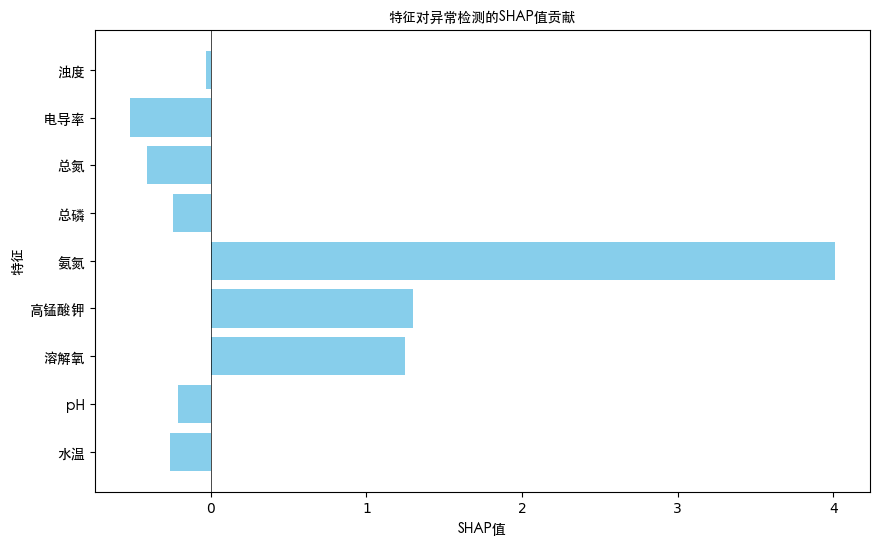

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# 设置中文字体
zh_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # 使用你找到的字体路径
prop = font_manager.FontProperties(fname=zh_font_path)  # 创建FontProperties对象

# 选择第一个样本的SHAP值
sample_index = 0  # 选择样本的索引
shap_values_sample = shap_new_df.iloc[sample_index]

# 获取特征名称
feature_names = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_values_sample, color='skyblue')
plt.axvline(0, color='black', linewidth=0.5)  # 添加参考线
plt.title('特征对异常检测的SHAP值贡献', fontproperties=prop)  # 应用字体
plt.xlabel('SHAP值', fontproperties=prop)
plt.ylabel('特征', fontproperties=prop)

# 设置y轴标签的字体
plt.yticks(fontproperties=prop)

plt.show()

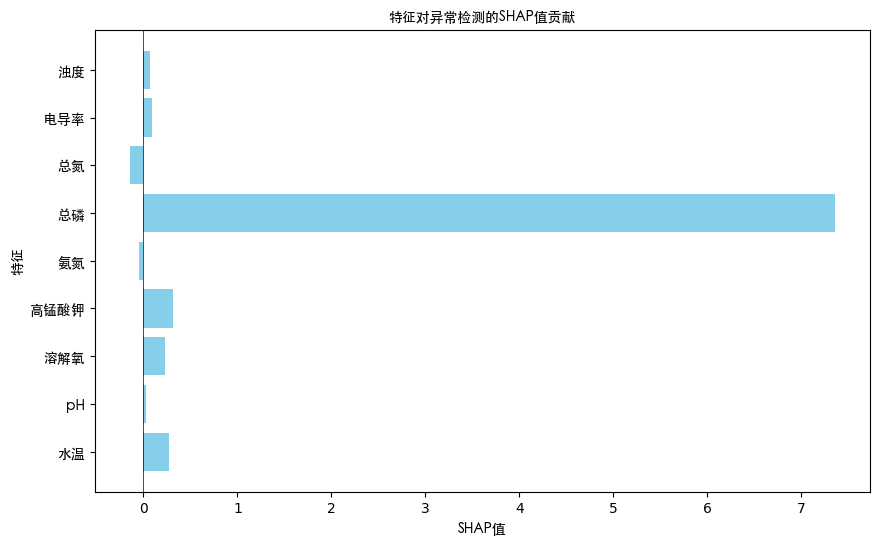

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# 设置中文字体
zh_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # 使用你找到的字体路径
prop = font_manager.FontProperties(fname=zh_font_path)  # 创建FontProperties对象

# 选择第一个样本的SHAP值
sample_index = 1  # 选择样本的索引
shap_values_sample = shap_new_df.iloc[sample_index]

# 获取特征名称
feature_names = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_values_sample, color='skyblue')
plt.axvline(0, color='black', linewidth=0.5)  # 添加参考线
plt.title('特征对异常检测的SHAP值贡献', fontproperties=prop)  # 应用字体
plt.xlabel('SHAP值', fontproperties=prop)
plt.ylabel('特征', fontproperties=prop)

# 设置y轴标签的字体
plt.yticks(fontproperties=prop)

plt.show()

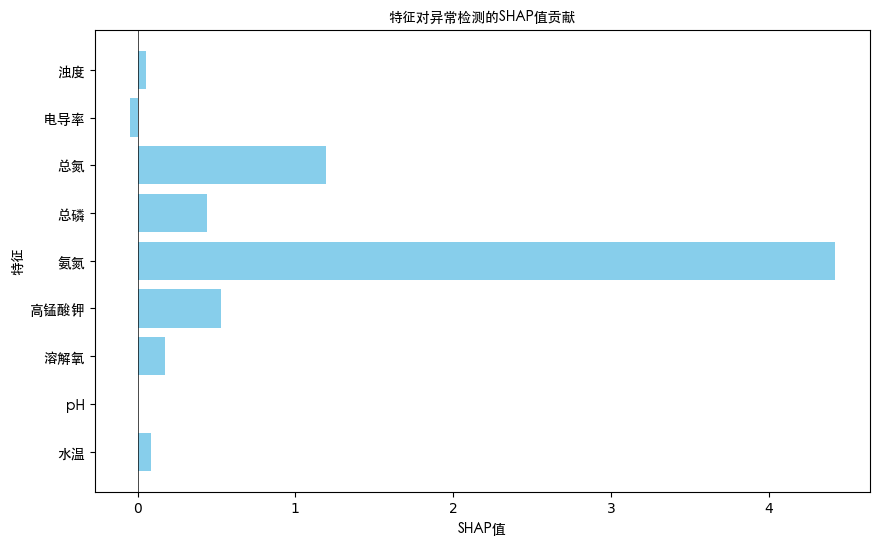

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# 设置中文字体
zh_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # 使用你找到的字体路径
prop = font_manager.FontProperties(fname=zh_font_path)  # 创建FontProperties对象

# 选择第一个样本的SHAP值
sample_index = 2  # 选择样本的索引
shap_values_sample = shap_new_df.iloc[sample_index]

# 获取特征名称
feature_names = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_values_sample, color='skyblue')
plt.axvline(0, color='black', linewidth=0.5)  # 添加参考线
plt.title('特征对异常检测的SHAP值贡献', fontproperties=prop)  # 应用字体
plt.xlabel('SHAP值', fontproperties=prop)
plt.ylabel('特征', fontproperties=prop)

# 设置y轴标签的字体
plt.yticks(fontproperties=prop)

plt.show()

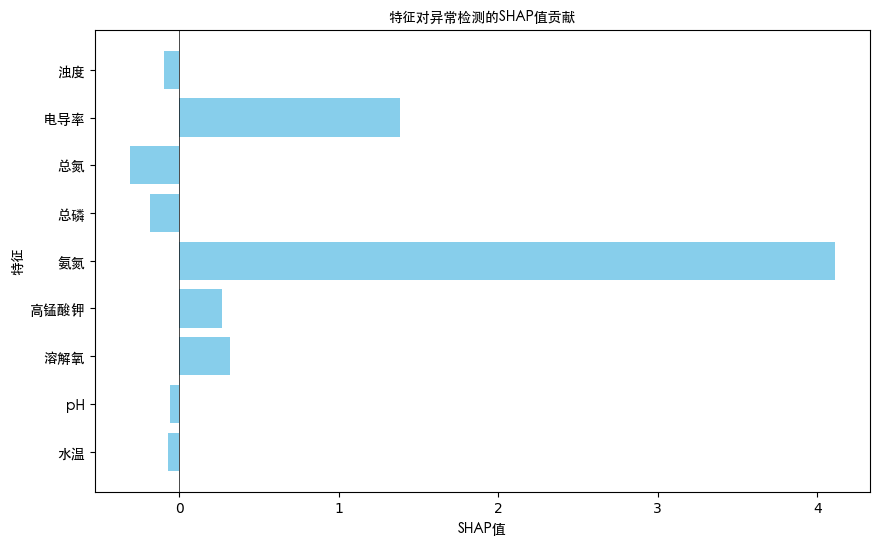

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# 设置中文字体
zh_font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # 使用你找到的字体路径
prop = font_manager.FontProperties(fname=zh_font_path)  # 创建FontProperties对象

# 选择第一个样本的SHAP值
sample_index = 3  # 选择样本的索引
shap_values_sample = shap_new_df.iloc[sample_index]

# 获取特征名称
feature_names = ['水温', 'pH', '溶解氧', '高锰酸钾', '氨氮', '总磷', '总氮', '电导率', '浊度']

# 绘制柱状图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, shap_values_sample, color='skyblue')
plt.axvline(0, color='black', linewidth=0.5)  # 添加参考线
plt.title('特征对异常检测的SHAP值贡献', fontproperties=prop)  # 应用字体
plt.xlabel('SHAP值', fontproperties=prop)
plt.ylabel('特征', fontproperties=prop)

# 设置y轴标签的字体
plt.yticks(fontproperties=prop)

plt.show()